# Cluster Billboards and sort to find row similar to a target

Frequently we don't have complete information about whether a billboard is available for booking. In the case that it is desired but unavailable, we need to find one or more similar replacement billboards. This model clusters billboards based on several features then the data is sorted by geographic distance and the closest billboards in the same cluster are shown.

In [140]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import pandas as pd
import numpy as np
import pygeohash as pgh
from sklearn import metrics, cluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic

%matplotlib inline

In [141]:
data = 'data/unit_data.csv'
df = pd.read_csv(data)
df.head()

id        lat        lon             size  height  width  \
0    lamar-50251-389906  41.284430 -96.052220  10' 6" x 22' 9"    10.5  22.75   
1    lamar-50622-389944  41.210830 -95.947200  10' 6" x 22' 9"    10.5  22.75   
2     lamar-1469-566363  39.171150 -84.478510  10' 6" x 22' 9"    10.5  22.75   
3  lamar-70020-30483836  30.453580 -87.686680     10' 6" x 36'    10.5  36.00   
4     lamar-1967-169799  44.389385 -91.008494        14' x 48'    14.0  48.00   

    price  rate_card_price  floor_price   cpm  impressions  unit_type  \
0   675.0            850.0          NaN  1.95       345364  billboard   
1   675.0            810.0          NaN  4.94       136544  billboard   
2  1200.0           1440.0          NaN  4.35       275720  billboard   
3  1750.0           2100.0          NaN  5.64       310528  billboard   
4  1400.0           1680.0          NaN  3.24       432576  billboard   

  media_type  supplier_id supplier_face_id                market  
0  Billboard           39            50251                 OMAHA  
1  Billboard           39            50622                 OMAHA  
2  Billboard           39             1469            CINCINNATI  
3  Billboard           39            70020      MOBILE-PENSACOLA  
4  Billboard           39             1967  LA CROSSE-EAU CLAIRE

In [142]:
df.dtypes

id                   object
lat                 float64
lon                 float64
size                 object
height              float64
width               float64
price               float64
rate_card_price     float64
floor_price         float64
cpm                 float64
impressions           int64
unit_type            object
media_type           object
supplier_id           int64
supplier_face_id     object
market               object
dtype: object

In [143]:
df.describe()

lat            lon        height          width  \
count  182898.000000  182898.000000  1.828980e+05  182898.000000   
mean       37.115557     -90.457625  5.789810e+02     103.593342   
std         4.872833      12.047432  2.085348e+05     174.004605   
min        21.294695    -158.000100  2.000000e+00       4.000000   
25%        33.591384     -95.585800  1.050000e+01      22.750000   
50%        36.858590     -87.625555  1.050000e+01      36.000000   
75%        40.907110     -81.952610  1.265000e+02     125.500000   
max        48.979920     102.273584  8.918320e+07   24144.000000   

               price  rate_card_price   floor_price            cpm  \
count  182898.000000    182500.000000    867.000000  182898.000000   
mean     1574.009464      1894.594918   2075.579008      14.456766   
std      3247.237307      4083.379029   4564.895218     868.232374   
min       100.000000         0.000000      0.000000       0.000000   
25%       600.000000       708.000000    114.000000       2.430000   
50%       885.000000      1060.000000    174.000000       4.160000   
75%      1500.000000      1800.000000   1000.000000       7.430000   
max    100000.000000    175000.000000  50000.000000  322580.650000   

        impressions    supplier_id  
count  1.828980e+05  182898.000000  
mean   4.005241e+05      99.090444  
std    6.873814e+05     224.032545  
min    0.000000e+00      28.000000  
25%    1.132080e+05      39.000000  
50%    2.217965e+05      39.000000  
75%    4.352150e+05      39.000000  
max    5.040216e+07    1798.000000

### drop invalid rows

In [144]:
print(df.isnull().sum())
df.dropna(subset=['supplier_face_id', 'rate_card_price'], inplace=True)
df.drop(df.loc[df['width'] > 18000].index, inplace=True)
df.drop(df.loc[df['height'] > 72000].index, inplace=True)
df.drop(df.loc[df['cpm'] > 300].index, inplace=True)
df.isnull().sum()

id                       0
lat                      0
lon                      0
size                     0
height                   0
width                    0
price                    0
rate_card_price        398
floor_price         182031
cpm                      0
impressions              0
unit_type                0
media_type               0
supplier_id              0
supplier_face_id        24
market                   0
dtype: int64


id                       0
lat                      0
lon                      0
size                     0
height                   0
width                    0
price                    0
rate_card_price          0
floor_price         181316
cpm                      0
impressions              0
unit_type                0
media_type               0
supplier_id              0
supplier_face_id         0
market                   0
dtype: int64

In [145]:
df.isnull().sum()

id                       0
lat                      0
lon                      0
size                     0
height                   0
width                    0
price                    0
rate_card_price          0
floor_price         181316
cpm                      0
impressions              0
unit_type                0
media_type               0
supplier_id              0
supplier_face_id         0
market                   0
dtype: int64

### generate features that will be used for clustering and sorting

In [146]:
df.height.apply(lambda h: round(h / 5))
df.width.apply(lambda w: round(w / 5))
df['sqft'] = [l[0] * l[1] for l in list(zip(df.height, df.width))]
df['size_ratio'] = [l[1] / l[0] for l in list(zip(df.height, df.width))]
df['geo_hash'] = [pgh.encode(l[0], l[1], precision=3) for l in list(zip(df.lat, df.lon))]
cols = ['id', 'supplier_id', 'sqft', 'size_ratio', 'geo_hash', 'price', 'cpm', 'impressions']
orig_df = df
df = df[cols]
df.head()

id  supplier_id     sqft  size_ratio geo_hash   price  \
0    lamar-50251-389906           39  238.875    2.166667      9z7   675.0   
1    lamar-50622-389944           39  238.875    2.166667      9z7   675.0   
2     lamar-1469-566363           39  238.875    2.166667      dng  1200.0   
3  lamar-70020-30483836           39  378.000    3.428571      dj3  1750.0   
4     lamar-1967-169799           39  672.000    3.428571      9zz  1400.0   

    cpm  impressions  
0  1.95       345364  
1  4.94       136544  
2  4.35       275720  
3  5.64       310528  
4  3.24       432576

### scale features and create dummies (not scaled) for suppliers

In [147]:
scaler = MinMaxScaler()

# exclude geo_hash and media_type because they are dummies now
exclude = ['id', 'supplier_id', 'lat', 'lon', 'geo_hash', 'media_type']

feature_cols = list(df.columns.difference(exclude))
orig_cols = df.columns
# don't scale the dummies
df = pd.get_dummies(df, columns=['supplier_id'])
X = scaler.fit_transform(df[feature_cols])
# scale only the feature cols, then add the dummies and combine to an array
new_x = pd.concat([pd.DataFrame(X, columns=feature_cols), df[df.columns.difference(exclude)]])
new_x.dropna(axis = 0, how ='any', inplace=True)
X = new_x.to_numpy()
X[:5]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


array([[1.95000e+00, 3.45364e+05, 6.75000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.94000e+00, 1.36544e+05, 6.75000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.35000e+00, 2.75720e+05, 1.20000e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.64000e+00, 3.10528e+05, 1.75000e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.24000e+00, 4.32576e+05, 1.40000e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

### find optimal clusters and silhouette score

In [148]:
wcss = []
ss = []
iter_range = range(6, 18)
for i in iter_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    ss.append(metrics.silhouette_score(X, labels, metric='euclidean'))

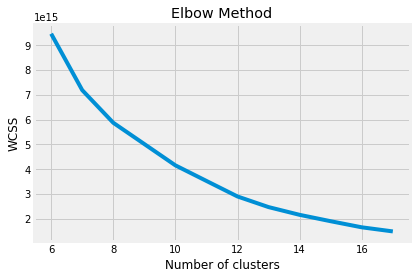

In [149]:
plt.plot(iter_range, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

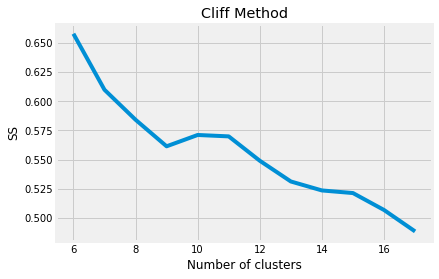

In [150]:
plt.plot(iter_range, ss)
plt.title('Cliff Method')
plt.xlabel('Number of clusters')
plt.ylabel('SS')
plt.show()

In [151]:
kmeans = cluster.KMeans(n_clusters=14, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_
metrics.silhouette_score(X, labels, metric='euclidean')

0.5236759858951736

### add labels to the dataframe

In [152]:
df['label'] = labels
df.head()

id     sqft  size_ratio geo_hash   price   cpm  \
0    lamar-50251-389906  238.875    2.166667      9z7   675.0  1.95   
1    lamar-50622-389944  238.875    2.166667      9z7   675.0  4.94   
2     lamar-1469-566363  238.875    2.166667      dng  1200.0  4.35   
3  lamar-70020-30483836  378.000    3.428571      dj3  1750.0  5.64   
4     lamar-1967-169799  672.000    3.428571      9zz  1400.0  3.24   

   impressions  supplier_id_28  supplier_id_29  supplier_id_30  ...  \
0       345364               0               0               0  ...   
1       136544               0               0               0  ...   
2       275720               0               0               0  ...   
3       310528               0               0               0  ...   
4       432576               0               0               0  ...   

   supplier_id_1508  supplier_id_1516  supplier_id_1518  supplier_id_1554  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   supplier_id_1707  supplier_id_1717  supplier_id_1770  supplier_id_1797  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   supplier_id_1798  label  
0                 0      8  
1                 0      2  
2                 0      8  
3                 0      8  
4                 0      0  

[5 rows x 257 columns]

### add back the original features for plotting and calculating distance

In [153]:
plot_cols = ['supplier_id', 'sqft', 'size_ratio', 'price', 'impressions']
df['supplier_id'] = orig_df['supplier_id']
df['market'] = orig_df['market']
df['lat'] = orig_df['lat']
df['lon'] = orig_df['lon']
df[['label', 'id', 'supplier_id', 'sqft', 'size_ratio', 'geo_hash', 'price', 'cpm', 'impressions']].head()

label                    id  supplier_id     sqft  size_ratio geo_hash  \
0      8    lamar-50251-389906           39  238.875    2.166667      9z7   
1      2    lamar-50622-389944           39  238.875    2.166667      9z7   
2      8     lamar-1469-566363           39  238.875    2.166667      dng   
3      8  lamar-70020-30483836           39  378.000    3.428571      dj3   
4      0     lamar-1967-169799           39  672.000    3.428571      9zz   

    price   cpm  impressions  
0   675.0  1.95       345364  
1   675.0  4.94       136544  
2  1200.0  4.35       275720  
3  1750.0  5.64       310528  
4  1400.0  3.24       432576

### visual exploration, not too useful since there are so many features

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


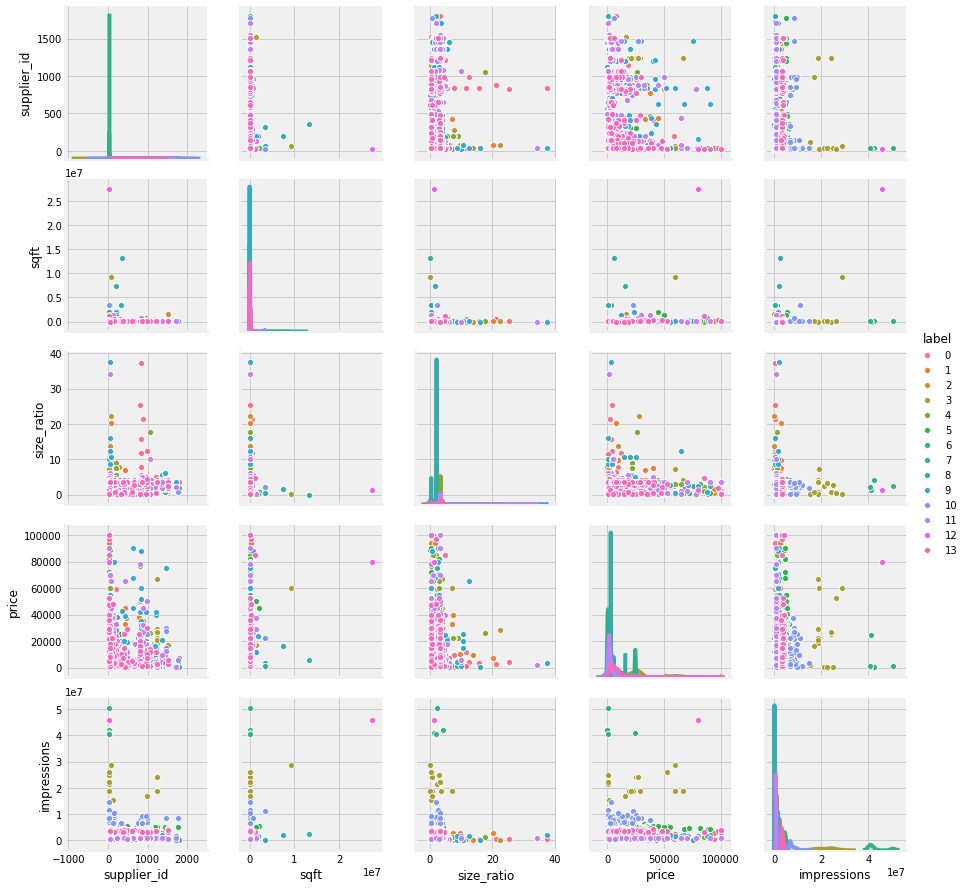

In [157]:
plot_cols = ['supplier_id', 'sqft', 'size_ratio', 'price', 'impressions']
sns.pairplot(df, x_vars=plot_cols, y_vars=plot_cols, hue='label');

### can identify targets by market

In [158]:
df[df['market'] == 'LOS ANGELES'].head()

id       sqft  size_ratio geo_hash   price    cpm  \
81   lamar-10054-30487709  10080.000    0.700000      9q5   975.0   4.27   
131   lamar-7062-30650872    480.000    3.333333      9qh  6500.0  19.89   
152     lamar-5344-350702    238.875    2.166667      9qh   950.0   2.36   
184    lamar-50026-216044    300.000    3.000000      9qn  1500.0  57.94   
279  lamar-79061-30656484     72.000    2.000000      9qh   340.0   2.17   

     impressions  supplier_id_28  supplier_id_29  supplier_id_30  ...  \
81        608248               0               0               0  ...   
131       326800               0               0               0  ...   
152       402032               0               0               0  ...   
184        25888               0               0               0  ...   
279       156796               0               0               0  ...   

     supplier_id_1707  supplier_id_1717  supplier_id_1770  supplier_id_1797  \
81                  0                 0                 0                 0   
131                 0                 0                 0                 0   
152                 0                 0                 0                 0   
184                 0                 0                 0                 0   
279                 0                 0                 0                 0   

     supplier_id_1798  label  supplier_id       market        lat         lon  
81                  0      0           39  LOS ANGELES  34.099400 -118.344000  
131                 0      8           39  LOS ANGELES  34.404885 -117.400341  
152                 0      0           39  LOS ANGELES  34.506220 -117.351830  
184                 0      2           39  LOS ANGELES  34.877906 -114.644261  
279                 0      2           39  LOS ANGELES  34.135840 -117.286690  

[5 rows x 261 columns]

### setting the target

In [159]:
# chooose target
y = df.loc[df['id'] == "lamar-70020-30483836"]
y1 = df.loc[df['id'] == "lamar-3793-30486729"]
y2 = df.loc[df['id'] == "la48-005-los-angeles"]
print(y)

                     id   sqft  size_ratio geo_hash   price   cpm  \
3  lamar-70020-30483836  378.0    3.428571      dj3  1750.0  5.64   

   impressions  supplier_id_28  supplier_id_29  supplier_id_30  ...  \
3       310528               0               0               0  ...   

   supplier_id_1707  supplier_id_1717  supplier_id_1770  supplier_id_1797  \
3                 0                 0                 0                 0   

   supplier_id_1798  label  supplier_id            market       lat       lon  
3                 0      8           39  MOBILE-PENSACOLA  30.45358 -87.68668  

[1 rows x 261 columns]


### limiting the data set to the same cluster and geo area

In [160]:
# find all rows with the same label and/or cluster
X = df[(df['label'] == y['label'].values[0]) & (df['geo_hash'] == y['geo_hash'].values[0])]
X = X[['id', 'lat', 'lon']]
X.head()

id        lat        lon
3    lamar-70020-30483836  30.453580 -87.686680
71   lamar-30132-30658330  30.890293 -88.020697
98   lamar-19802-30488118  30.461040 -87.324560
402    lamar-15721-341689  30.470580 -87.306070
451    lamar-13041-341433  30.461370 -87.299160

### calculate geographic distance between target and other rows 

In [161]:
output_array = []
for index1, row1 in X.iterrows():
    for index2, row2 in X.iterrows():
        if (row1['id'] != y['id'].values[0]) | (row1[0] == row2[0]):
            pass
        else:
            origin = (row1['lat'], row1['lon'])  # (latitude, longitude)
            dist = (row2['lat'], row2['lon'])
            h_dist = geodesic(origin, dist).kilometers
            output_array.append([row1.id, row2.id, h_dist])

In [162]:
distance_matrix_df = pd.DataFrame(output_array, columns=['id1', 'id2', 'geo_distance'])
distance_matrix_df.head()

id1                   id2  geo_distance
0  lamar-70020-30483836  lamar-30132-30658330     58.039868
1  lamar-70020-30483836  lamar-19802-30488118     34.788120
2  lamar-70020-30483836    lamar-15721-341689     36.600853
3  lamar-70020-30483836    lamar-13041-341433     37.227677
4  lamar-70020-30483836     lamar-1981-341865     44.050215

### sort and view the top 20 closest in the cluster

In [163]:
distance_matrix_df.sort_values(by=['geo_distance'], ascending=True, inplace=True)
distance_matrix_df[:20]

id1                   id2  geo_distance
440  lamar-70020-30483836  lamar-70021-30483837      0.158470
338  lamar-70020-30483836  lamar-70015-30483831      0.163916
77   lamar-70020-30483836    lamar-90511-406023      0.181325
766  lamar-70020-30483836    lamar-20381-404760      0.323135
518  lamar-70020-30483836    lamar-20312-404744      0.487058
802  lamar-70020-30483836    lamar-20311-404743      0.487058
540  lamar-70020-30483836    lamar-20371-404758      0.533481
433  lamar-70020-30483836  lamar-67061-30447875      0.793582
819  lamar-70020-30483836    lamar-80162-405796      0.797421
298  lamar-70020-30483836    lamar-53241-405381      1.021619
97   lamar-70020-30483836    lamar-63031-617945      1.160853
671  lamar-70020-30483836    lamar-20531-404799      1.179393
533  lamar-70020-30483836    lamar-53251-405383      1.181807
451  lamar-70020-30483836   lamar-4232-30635134      1.342981
522  lamar-70020-30483836   lamar-4231-30635133      1.342981
573  lamar-70020-30483836    lamar-61221-405463      1.354598
188  lamar-70020-30483836    lamar-63041-617947      1.457697
757  lamar-70020-30483836    lamar-62031-617930      1.513437
334  lamar-70020-30483836  lamar-67081-30483829      1.760739
744  lamar-70020-30483836    lamar-63061-617949      2.062514

### plot results

In [168]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [170]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df['geometry'] = geometry
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
us_map.plot(ax = ax, alpha = 0.4, color='grey')
geo_df.geometry.plot(marker='^', color='red', markersize=55, ax=ax, label = 'test')


<Figure size 432x288 with 0 Axes>

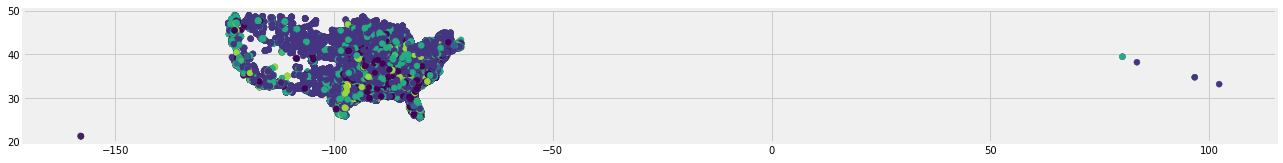

In [171]:
geo_df.plot(figsize=[20, 24], column=geo_df['label']);

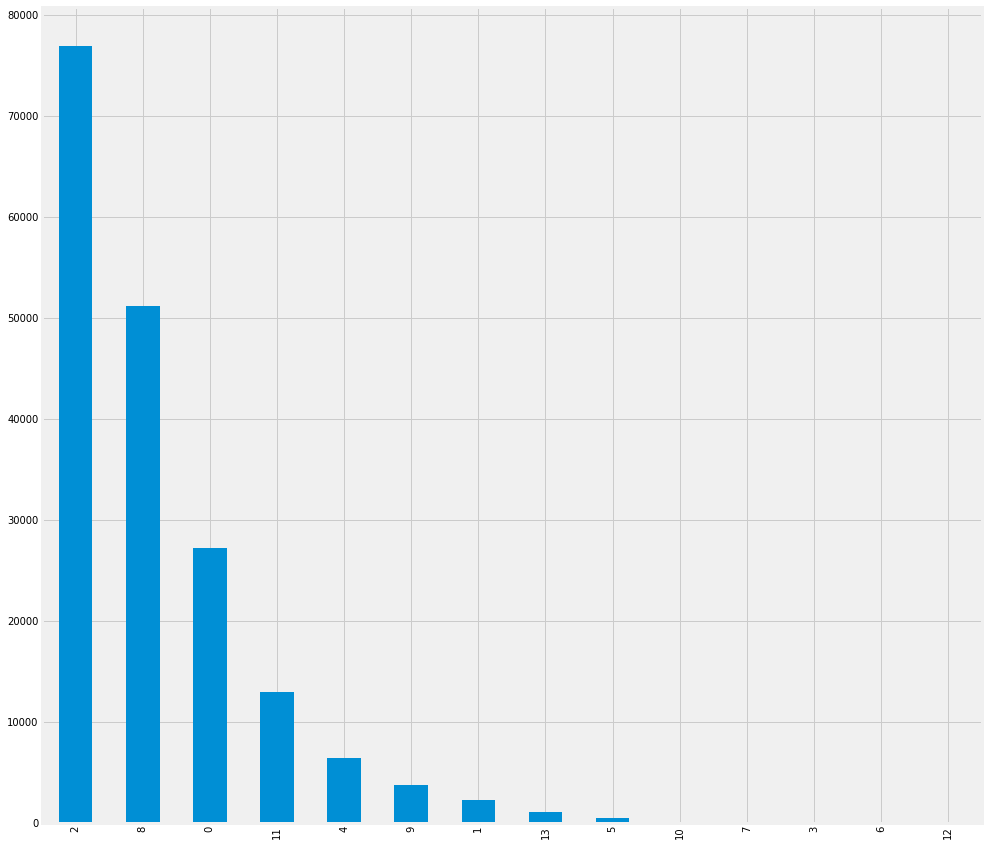

In [172]:
df.label.value_counts().plot(kind='bar', figsize=[15, 15]);

In [176]:
new_x['label'] = labels
new_x.describe()

cpm   impressions          price     size_ratio  \
count  182181.000000  1.821810e+05  182181.000000  182181.000000   
mean        6.710298  3.991858e+05    1565.020435       2.299153   
std         9.772094  6.628359e+05    3213.314124       1.067293   
min         0.000000  0.000000e+00     100.000000       0.024306   
25%         2.430000  1.135060e+05     600.000000       2.083333   
50%         4.150000  2.220360e+05     880.000000       2.166667   
75%         7.410000  4.351960e+05    1500.000000       3.428571   
max       292.170000  5.040216e+07  100000.000000      37.500000   

               sqft  supplier_id_1011  supplier_id_103  supplier_id_104  \
count  1.821810e+05     182181.000000    182181.000000    182181.000000   
mean   1.977650e+04          0.000082         0.000461         0.000148   
std    1.058505e+05          0.009074         0.021468         0.012173   
min    2.000000e+01          0.000000         0.000000         0.000000   
25%    2.388750e+02          0.000000         0.000000         0.000000   
50%    3.808800e+02          0.000000         0.000000         0.000000   
75%    3.400000e+04          0.000000         0.000000         0.000000   
max    2.736728e+07          1.000000         1.000000         1.000000   

       supplier_id_1058  supplier_id_1064  ...  supplier_id_954  \
count     182181.000000     182181.000000  ...    182181.000000   
mean           0.000033          0.000137  ...         0.003661   
std            0.005739          0.011714  ...         0.060397   
min            0.000000          0.000000  ...         0.000000   
25%            0.000000          0.000000  ...         0.000000   
50%            0.000000          0.000000  ...         0.000000   
75%            0.000000          0.000000  ...         0.000000   
max            1.000000          1.000000  ...         1.000000   

       supplier_id_955  supplier_id_958  supplier_id_96  supplier_id_97  \
count     182181.00000    182181.000000   182181.000000   182181.000000   
mean           0.00006         0.000049        0.003409        0.000346   
std            0.00777         0.007028        0.058285        0.018593   
min            0.00000         0.000000        0.000000        0.000000   
25%            0.00000         0.000000        0.000000        0.000000   
50%            0.00000         0.000000        0.000000        0.000000   
75%            0.00000         0.000000        0.000000        0.000000   
max            1.00000         1.000000        1.000000        1.000000   

       supplier_id_98  supplier_id_985  supplier_id_99  supplier_id_992  \
count   182181.000000    182181.000000   182181.000000    182181.000000   
mean         0.000412         0.000736        0.000104         0.000005   
std          0.020286         0.027111        0.010212         0.002343   
min          0.000000         0.000000        0.000000         0.000000   
25%          0.000000         0.000000        0.000000         0.000000   
50%          0.000000         0.000000        0.000000         0.000000   
75%          0.000000         0.000000        0.000000         0.000000   
max          1.000000         1.000000        1.000000         1.000000   

               label  
count  182181.000000  
mean        4.303396  
std         3.614162  
min         0.000000  
25%         2.000000  
50%         2.000000  
75%         8.000000  
max        13.000000  

[8 rows x 255 columns]

In [178]:
label_2_df = new_x[new_x['label'] == 2]
del label_2_df['label']
label_2_df.describe()

cpm    impressions         price    size_ratio          sqft  \
count  76909.000000   76909.000000  76909.000000  76909.000000  7.690900e+04   
mean      10.412042   99934.928214    796.409398      2.049276  9.625378e+03   
std       12.988264   46577.446067   1018.857507      0.837210  2.144644e+04   
min        0.010000       0.000000    100.000000      0.050000  2.000000e+01   
25%        4.440000   61472.000000    450.000000      2.000000  2.388750e+02   
50%        6.940000   99820.000000    675.000000      2.166667  2.388750e+02   
75%       11.670000  139136.000000    900.000000      2.166667  8.000000e+02   
max      292.170000  183344.000000  52500.000000     22.373494  1.468800e+06   

       supplier_id_1011  supplier_id_103  supplier_id_104  supplier_id_1058  \
count           76909.0          76909.0     76909.000000           76909.0   
mean                0.0              0.0         0.000091               0.0   
std                 0.0              0.0         0.009540               0.0   
min                 0.0              0.0         0.000000               0.0   
25%                 0.0              0.0         0.000000               0.0   
50%                 0.0              0.0         0.000000               0.0   
75%                 0.0              0.0         0.000000               0.0   
max                 0.0              0.0         1.000000               0.0   

       supplier_id_1064  ...  supplier_id_953  supplier_id_954  \
count           76909.0  ...     76909.000000     76909.000000   
mean                0.0  ...         0.001456         0.002392   
std                 0.0  ...         0.038134         0.048854   
min                 0.0  ...         0.000000         0.000000   
25%                 0.0  ...         0.000000         0.000000   
50%                 0.0  ...         0.000000         0.000000   
75%                 0.0  ...         0.000000         0.000000   
max                 0.0  ...         1.000000         1.000000   

       supplier_id_955  supplier_id_958  supplier_id_96  supplier_id_97  \
count          76909.0          76909.0    76909.000000    76909.000000   
mean               0.0              0.0        0.005682        0.000065   
std                0.0              0.0        0.075165        0.008063   
min                0.0              0.0        0.000000        0.000000   
25%                0.0              0.0        0.000000        0.000000   
50%                0.0              0.0        0.000000        0.000000   
75%                0.0              0.0        0.000000        0.000000   
max                0.0              0.0        1.000000        1.000000   

       supplier_id_98  supplier_id_985  supplier_id_99  supplier_id_992  
count         76909.0     76909.000000         76909.0          76909.0  
mean              0.0         0.000013             0.0              0.0  
std               0.0         0.003606             0.0              0.0  
min               0.0         0.000000             0.0              0.0  
25%               0.0         0.000000             0.0              0.0  
50%               0.0         0.000000             0.0              0.0  
75%               0.0         0.000000             0.0              0.0  
max               0.0         1.000000             0.0              0.0  

[8 rows x 254 columns]

In [ ]:
X_2 = label_2_df.to_numpy()

wcss = []
ss = []
iter_range = range(2, 8)
for i in iter_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_2)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    ss.append(metrics.silhouette_score(X_2, labels, metric='euclidean'))

In [ ]:
plt.plot(iter_range, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
plt.plot(iter_range, ss)
plt.title('Cliff Method')
plt.xlabel('Number of clusters')
plt.ylabel('SS')
plt.show()

In [ ]:
kmeans = cluster.KMeans(n_clusters=14, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_
metrics.silhouette_score(X, labels, metric='euclidean')